## 1. 필요한 패키지 불러오기

In [174]:
import numpy as np
import pandas as pd
import torch
import os
from torch import nn
from torch.utils.data import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
from fastprogress import master_bar, progress_bar
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## 2. 데이터 불러오기

In [175]:
data_dir = "./data/카사코리아 투자 현황v2.xlsx"
time_column = '일자'
format = '%y.%m.%d'

In [176]:
data = pd.read_excel(data_dir)
data[time_column] = pd.to_datetime(data[time_column], format=format)
data = data.sort_values(by = time_column).reset_index(drop = True)
data.columns = ['일자', '거래량', '시가', '고가', '저가', '종가', '배당금', '환율', '코스피', '시장금리']
for i in range(data.shape[0]):
    if pd.isna(data['코스피'][i]):
        data['코스피'][i] = data['코스피'][i-1]
data.head()

/tmp/ipykernel_21031/1548617826.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['코스피'][i] = data['코스피'][i-1]


,일자,거래량,시가,고가,저가,종가,배당금,환율,코스피,시장금리
0,2021-07-27,7565,4980,5000,4900,4910,469841.269841,1153.2,3232.53,1.380
1,2021-07-28,5898,4930,4940,4840,4900,469841.269841,1150.2,3236.86,1.419
2,2021-07-29,3750,4900,4920,4820,4820,469841.269841,1154.8,3242.65,1.431
3,2021-07-30,3308,4840,4860,4800,4840,469841.269841,1147.4,3202.32,1.417
4,2021-08-02,2584,5000,5000,4840,4870,469841.269841,1147.5,3223.04,1.435


### (1) Input & Target Variable 정의

In [177]:
Input_columns = ['거래량', '시가', '고가', '저가', '배당금', '환율', '코스피', '시장금리', '종가']
Target_column = '종가'

### (2) 정규화

In [178]:
Normalization_Method = 'MinMax'  ## (Z-norm, MinMax)

In [179]:
if Normalization_Method == 'Z-norm':
    print("Z-norm method is selected.")
    Scalar_transform = StandardScaler().fit(data.loc[:, [Target_column]])
    data.loc[:, [Target_column]] = Scalar_transform.transform(data.loc[:, [Target_column]])
    Input_transform = StandardScaler().fit(data.loc[:, Input_columns])
    data.loc[:, Input_columns] = Input_transform.transform(data.loc[:, Input_columns])
elif Normalization_Method == 'MinMax':
    print("Min-Max Normalization method is selected.")
    Scalar_transform = MinMaxScaler(feature_range=(-1, 1)).fit(data.loc[:, [Target_column]])
    data.loc[:, [Target_column]] = Scalar_transform.transform(data.loc[:, [Target_column]])
    Input_transform = MinMaxScaler().fit(data.loc[:, Input_columns])
    data.loc[:, Input_columns] = Input_transform.transform(data.loc[:, Input_columns])
else:
    print("Error: Choice Nomaliztion Method in (Z-norm, MinMax).")


Min-Max Normalization method is selected.


### (3) Transform Dataset with Sliding Windows

In [180]:
dataset = np.array(data.loc[:, [Target_column]])

In [181]:
def sliding_windows(data, Input_columns, Target_column, seq_length):
    x = []
    y = []

    data_y = np.array(data.loc[:, [Target_column]])
    data_x = np.array(data.loc[:, Input_columns])
    

    for i in range(len(data_y)-seq_length):
        _x = data_x[i:(i+seq_length)]
        _y = data_y[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [182]:
seq_length = 5
x, y = sliding_windows(data, Input_columns, Target_column, seq_length)
print(x.shape)
print(y.shape)

(494, 5, 9)
(494, 1)


### (4) Make Torch Dataset

In [183]:
train_ratio = 0.8

In [184]:
train_size = int(len(y) * train_ratio)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## 3. LSTM Model 생성

### (1) Model 생성

In [185]:
device = 'cuda:0'

In [186]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.25)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

### (2) Loss 정의

In [187]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

## 4. Training

### (1) 학습 파라미터 정의


In [189]:
num_epochs = 1000
learning_rate = 1e-4
input_size = 9
hidden_size = 64
num_layers = 1
num_classes = 1

best_model_path = './experiment'
os.makedirs(best_model_path, exist_ok = True)
os.makedirs(os.path.join(best_model_path, 'lstm_model'), exist_ok = True)


### (2) LSTM 모델 정의

In [190]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

/home/jongwook95.lee/miniforge3/envs/torch100/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM(
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(9, 64, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

### (3) Set Criterion Optimzer and scheduler

In [191]:
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)

### (4) Train

In [192]:
best_rmse = np.inf
best_epoch = 0

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    loss.backward()
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)

    if vall_loss.cpu().data.numpy() < best_rmse:
      best_epoch = epoch
      best_rmse = vall_loss.cpu().data.numpy()
      torch.save(lstm, os.path.join(os.path.join(best_model_path, 'lstm_model'), 'best_lstm_model.pt'))

    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

print("Best LSTM Model: Epoch = {}, Valid Loss = {}".format(best_epoch, best_rmse))

Epoch: 0, loss: 0.76565 valid loss:  0.14611 
Epoch: 50, loss: 0.56617 valid loss:  0.07963 
Epoch: 100, loss: 0.37192 valid loss:  0.02555 
Epoch: 150, loss: 0.21793 valid loss:  0.01537 
Epoch: 200, loss: 0.18169 valid loss:  0.03746 
Epoch: 250, loss: 0.14443 valid loss:  0.02727 
Epoch: 300, loss: 0.15540 valid loss:  0.02005 
Epoch: 350, loss: 0.16493 valid loss:  0.01468 
Epoch: 400, loss: 0.13064 valid loss:  0.01116 
Epoch: 450, loss: 0.14489 valid loss:  0.00925 
Epoch: 500, loss: 0.15252 valid loss:  0.00855 
Epoch: 550, loss: 0.12525 valid loss:  0.00853 
Epoch: 600, loss: 0.13348 valid loss:  0.00887 
Epoch: 650, loss: 0.16092 valid loss:  0.00937 
Epoch: 700, loss: 0.15910 valid loss:  0.00989 
Epoch: 750, loss: 0.14328 valid loss:  0.01032 
Epoch: 800, loss: 0.12775 valid loss:  0.01080 
Epoch: 850, loss: 0.13311 valid loss:  0.01116 
Epoch: 900, loss: 0.14995 valid loss:  0.01162 
Epoch: 950, loss: 0.16760 valid loss:  0.01181 
Best LSTM Model: Epoch = 524, Valid Loss = 

### (5) Load Best LSTM Model

In [193]:
lstm = torch.load(os.path.join(os.path.join(best_model_path, 'lstm_model'), 'best_lstm_model.pt'))

## 5. Inference

### (1) Train 성능 평가

In [194]:
lstm.eval()
train_predict = lstm(trainX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = trainY.data.numpy()

from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(data_predict[:, 0], dataY_plot[:, 0])**0.5
print("Train RMSE: {}".format(RMSE))

Train RMSE: 0.21071858879376235


In [195]:
train_error = np.abs(data_predict[:, 0] - dataY_plot[:, 0])
print("Train Error 최솟값: {}".format(min(train_error)))
print("Train Error 1 분위수: {}".format(np.percentile(train_error, 25)))
print("Train Error 중앙값: {}".format(np.median(train_error)))
print("Train Error 평균: {}".format(np.mean(train_error)))
print("Train Error 3분위수: {}".format(np.percentile(train_error, 75)))
print("Train Error 최댓값: {}".format(max(train_error)))

Train Error 최솟값: 0.00014322996139526367
Train Error 1 분위수: 0.13933943212032318
Train Error 중앙값: 0.21546000242233276
Train Error 평균: 0.19340340793132782
Train Error 3분위수: 0.2494995892047882
Train Error 최댓값: 0.41779541969299316


### (2) Test 성능 평가

In [196]:
lstm.eval()
train_predict = lstm(testX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = testY.data.numpy()

from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(data_predict[:, 0], dataY_plot[:, 0])**0.5
print("Test RMSE: {}".format(RMSE))

Test RMSE: 0.09215837681341545


In [197]:
test_error = np.abs(data_predict[:, 0] - dataY_plot[:, 0])
print("Test Error 최솟값: {}".format(min(test_error)))
print("Test Error 1 분위수: {}".format(np.percentile(test_error, 25)))
print("Test Error 중앙값: {}".format(np.median(test_error)))
print("Test Error 평균: {}".format(np.mean(test_error)))
print("Test Error 3분위수: {}".format(np.percentile(test_error, 75)))
print("Test Error 최댓값: {}".format(max(test_error)))

Test Error 최솟값: 0.001529097557067871
Test Error 1 분위수: 0.021065689623355865
Test Error 중앙값: 0.045630618929862976
Test Error 평균: 0.06336068361997604
Test Error 3분위수: 0.07846856117248535
Test Error 최댓값: 0.4236128032207489


### (3) 예측 시각화

#### - Test 구간에 대해서만

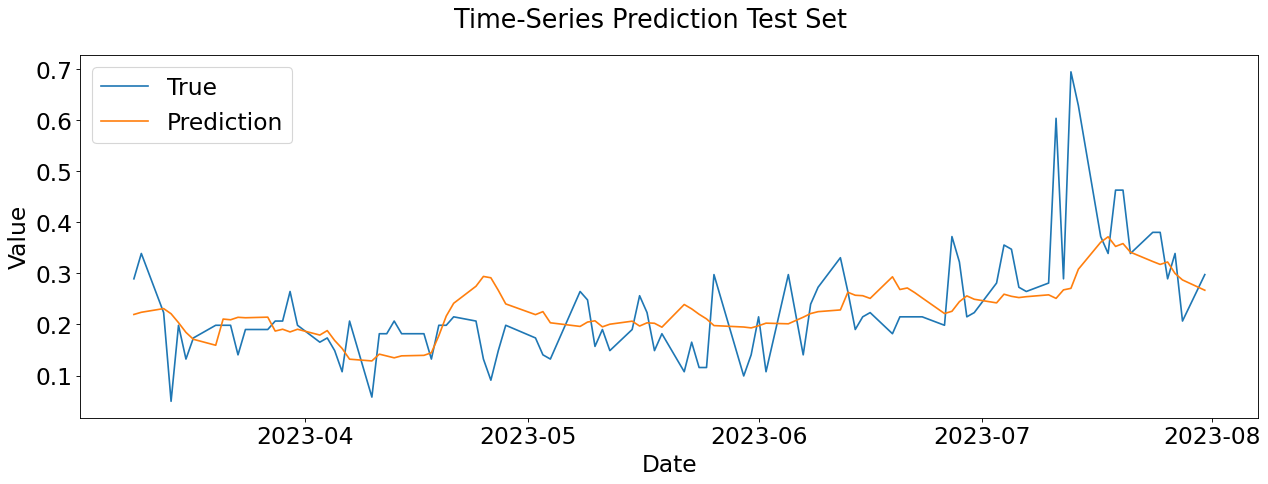

In [198]:
dates_list = data['일자'][-testX.shape[0]:]

lstm.eval()
train_predict = lstm(testX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = testY.data.numpy()

df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list])

# Plot 
plt.figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels[0])
plt.plot(df_predict[0])
plt.legend(['True', 'Prediction'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Value',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()